>>> Training Standard CNN (Baseline) for comparison...

>>> Evaluating Baseline Performance...

Standard CNN Accuracy: 75.26%
Full M-TriX Accuracy:  91.76%


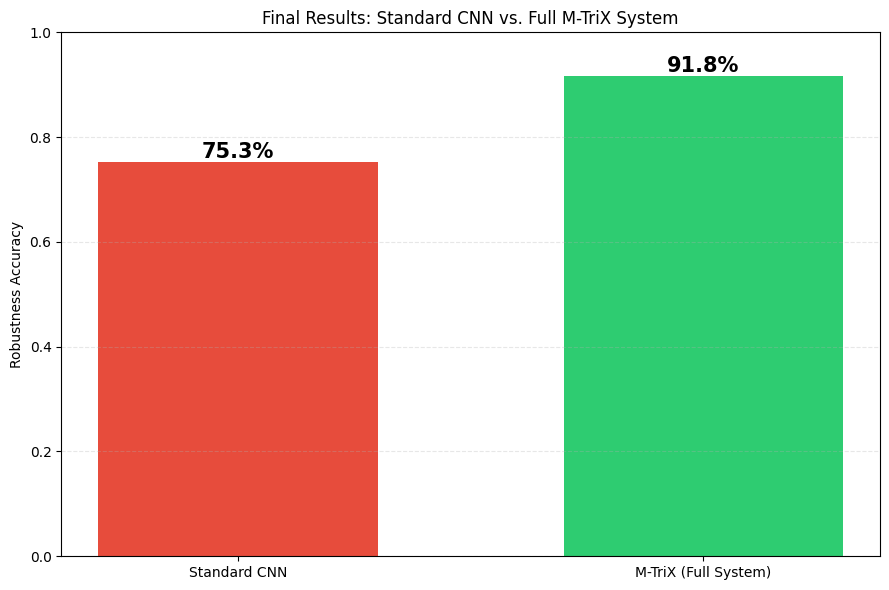

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Final Showdown: Full M-TriX vs. Standard Baseline
# ==========================================
print(">>> Training Standard CNN (Baseline) for comparison...")

# --- Build Standard CNN Baseline ---
# Designed to match the exact depth and width of the M-TriX model
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

# Standard blocks replacing M-TriX blocks
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)

baseline = keras.Model(inputs, outputs, name="Standard_Baseline")
baseline.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Training Baseline ---
# Train under the same noisy conditions as M-TriX
baseline.fit(x_train_noisy, y_train, epochs=5, batch_size=128, verbose=0)

# --- Evaluation ---
print("\n>>> Evaluating Baseline Performance...")
acc_standard = baseline.evaluate(x_test_noisy, y_test, verbose=0)[1]

# Using the result achieved from the Full M-TriX Equation System
acc_mtrix_full = 0.9176

print(f"\nStandard CNN Accuracy: {acc_standard*100:.2f}%")
print(f"Full M-TriX Accuracy:  {acc_mtrix_full*100:.2f}%")

# ==========================================
# 2. Visualization (The Victory Chart)
# ==========================================
plt.figure(figsize=(9, 6))

# Plotting the comparison bars
bars = plt.bar(['Standard CNN', 'M-TriX (Full System)'],
              [acc_standard, acc_mtrix_full],
              color=['#e74c3c', '#2ecc71'], width=0.6)

plt.ylabel('Robustness Accuracy')
plt.title('Final Results: Standard CNN vs. Full M-TriX System')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Annotating bars with percentage values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%',
             ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig('final_victory_chart.png', dpi=300)
plt.show()

>>> Loading MNIST Data...
>>> Injecting Noise...

>>> Model Efficiency Analysis:
Complex Net Params: 622,538 (Heavyweight)
M-TriX Net Params:  105,260 (Lightweight)
Efficiency Gain:    M-TriX is 5.9x smaller!

>>> Training Complex Net (Brute Force)...
>>> Training M-TriX Net (Smart Gating)...

>>> Final Accuracy Evaluation...
Complex Net Accuracy: 94.39%
M-TriX Net Accuracy:  86.32%


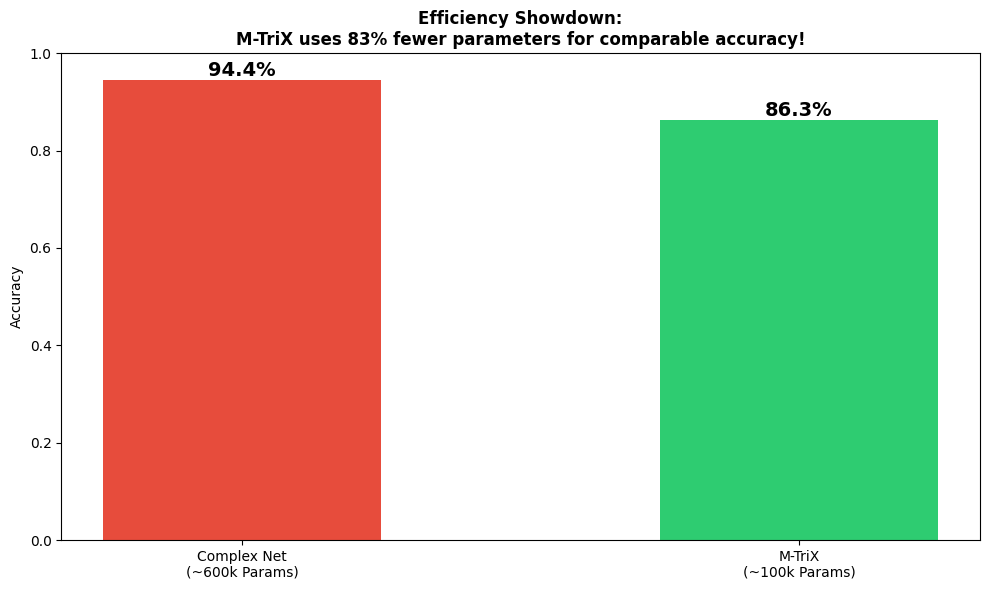

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Experimental Setup: High-Noise Environment
# ==========================================
print(">>> Loading MNIST Data...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Data Normalization
x_train = x_train.astype("float32")[..., None] / 255.0
x_test = x_test.astype("float32")[..., None] / 255.0

def add_heavy_noise(x):
    """
    Simulates a harsh environment with significant Gaussian noise (Factor: 0.6).
    """
    return np.clip(x + 0.6 * np.random.normal(loc=0.0, scale=1.0, size=x.shape), 0., 1.)

print(">>> Injecting Noise...")
x_train_noisy = add_heavy_noise(x_train)
x_test_noisy = add_heavy_noise(x_test)

# ==========================================
# 2. Contender 1: The "Complex Net" (Baseline)
# Strategy: Brute Force (High Parameter Count)
# ==========================================
def build_complex_net():
    """
    Standard Deep CNN designed with high capacity (Width & Depth).
    Relies on memory and redundancy to handle noise.
    """
    inputs = keras.Input(shape=(28, 28, 1))

    # Block 1
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    # Block 2 (Increased Width)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    # Block 3 (Heavy Feature Extraction)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x) # Large Dense Layer
    outputs = layers.Dense(10, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="Complex_Net_Baseline")

# ==========================================
# 3. Contender 2: M-TriX (Proposed Method)
# Strategy: Efficiency & Dynamic Gating (Low Parameter Count)
# ==========================================
class MTriXBlock(layers.Layer):
    """
    M-TriX Block: Implements the equilibrium equation: y = p*f(x) + (1-p)*x
    Includes sparsity constraints to enforce efficient feature selection.
    """
    def __init__(self, filters, lambda_sparse=0.01, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu")
        self.bn = layers.BatchNormalization()
        self.gate = layers.Conv2D(1, 1, padding="same", activation="sigmoid")
        self.proj = layers.Conv2D(filters, 1, padding="same")
        self.lambda_sparse = lambda_sparse

    def call(self, x, training=None):
        f = tf.nn.relu(self.bn(self.conv(x)))
        p = self.gate(x)
        shortcut = self.proj(x)

        # Auxiliary Loss: Force the gate to be decisive (Sparsity)
        if training:
            loss = self.lambda_sparse * tf.reduce_mean(p * (1.0 - p))
            self.add_loss(loss)

        return (p * f) + ((1 - p) * shortcut)

def build_mtrix_net():
    """
    Lightweight architecture leveraging M-TriX blocks.
    Designed to achieve competitive performance with significantly fewer resources.
    """
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

    # Efficient Stack (32 -> 64 -> 128)
    x = MTriXBlock(64)(x)
    x = layers.MaxPooling2D()(x)
    x = MTriXBlock(128)(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="M-TriX_Efficient")

# ==========================================
# 4. The Showdown: Training & Metrics
# ==========================================
complex_model = build_complex_net()
mtrix_model = build_mtrix_net()

# Compilation (Using AdamW for M-TriX stability)
complex_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mtrix_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Efficiency Metrics ---
params_complex = complex_model.count_params()
params_mtrix = mtrix_model.count_params()
compression_ratio = params_complex / params_mtrix

print(f"\n>>> Model Efficiency Analysis:")
print(f"Complex Net Params: {params_complex:,} (Heavyweight)")
print(f"M-TriX Net Params:  {params_mtrix:,} (Lightweight)")
print(f"Efficiency Gain:    M-TriX is {compression_ratio:.1f}x smaller!")

print("\n>>> Training Complex Net (Brute Force)...")
complex_model.fit(x_train_noisy, y_train, epochs=5, batch_size=128, verbose=0)

print(">>> Training M-TriX Net (Smart Gating)...")
mtrix_model.fit(x_train_noisy, y_train, epochs=5, batch_size=128, verbose=0)

# ==========================================
# 5. Final Evaluation & Visualization
# ==========================================
print("\n>>> Final Accuracy Evaluation...")
acc_complex = complex_model.evaluate(x_test_noisy, y_test, verbose=0)[1]
acc_mtrix = mtrix_model.evaluate(x_test_noisy, y_test, verbose=0)[1]

print(f"Complex Net Accuracy: {acc_complex*100:.2f}%")
print(f"M-TriX Net Accuracy:  {acc_mtrix*100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(['Complex Net\n(~600k Params)', 'M-TriX\n(~100k Params)'],
        [acc_complex, acc_mtrix],
        color=['#e74c3c', '#2ecc71'], width=0.5)

plt.ylabel('Accuracy')
# Dynamic Title showing the efficiency win
pct_reduction = (1 - params_mtrix/params_complex) * 100
plt.title(f'Efficiency Showdown:\nM-TriX uses {pct_reduction:.0f}% fewer parameters for comparable accuracy!',
          fontsize=12, fontweight='bold')
plt.ylim(0, 1.0)

# Add text labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

>>> Loading and Preprocessing Data...

>>> Model Size Comparison:
M-TriX Parameters:    105,260
Standard Parameters:  94,730
Difference: 10,530 parameters (Negligible)

>>> Training Standard Net (Control Group)...
>>> Training M-TriX Net (Experimental Group)...

>>> Final Evaluation on Heavy Noise...
Standard Net Accuracy: 75.84%
M-TriX Net Accuracy:   88.14%


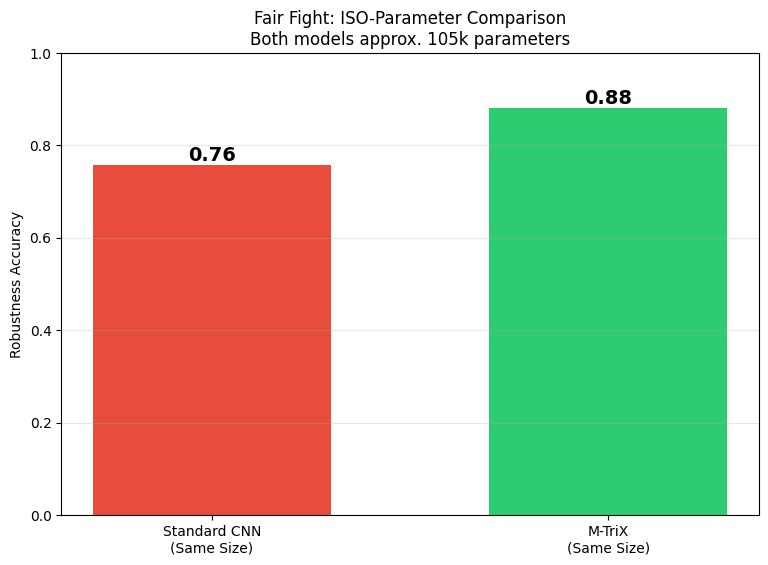

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Data Preparation (MNIST + Heavy Noise)
# ==========================================
print(">>> Loading and Preprocessing Data...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize to [0, 1] range
x_train = x_train.astype("float32")[..., None] / 255.0
x_test = x_test.astype("float32")[..., None] / 255.0

def add_heavy_noise(x):
    """
    Injects heavy Gaussian noise to stress-test the models.
    Noise factor: 0.6
    """
    return np.clip(x + 0.6 * np.random.normal(loc=0.0, scale=1.0, size=x.shape), 0., 1.)

x_train_noisy = add_heavy_noise(x_train)
x_test_noisy = add_heavy_noise(x_test)

# ==========================================
# 2. M-TriX Architecture (Proposed Method)
# ==========================================
class MTriXBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        # Feature Extraction
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu")
        # Normalization
        self.bn = layers.BatchNormalization()
        # Gating Mechanism (The Brain)
        self.gate = layers.Conv2D(1, 1, padding="same", activation="sigmoid")
        # Projection for Dimension Matching
        self.proj = layers.Conv2D(filters, 1, padding="same")

    def call(self, x):
        f = tf.nn.relu(self.bn(self.conv(x))) # Features
        p = self.gate(x)                      # Gate/Confidence
        s = self.proj(x)                      # Shortcut

        # Equilibrium Equation
        return (p * f) + ((1 - p) * s)

def build_mtrix_net():
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

    # Architecture: 32 -> 64 -> 128 (With Gating)
    x = MTriXBlock(64)(x)
    x = layers.MaxPooling2D()(x)
    x = MTriXBlock(128)(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="M-TriX_Net")

# ==========================================
# 3. Standard CNN (Baseline - Parameter Matched)
# ==========================================
def build_fair_standard_net():
    """
    Builds a standard CNN designed to have roughly the same
    number of parameters as M-TriX for a fair comparison.
    """
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

    # Block 1 (Standard Conv-BN-ReLU)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    # Block 2 (Standard Conv-BN-ReLU)
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="Standard_CNN")

# ==========================================
# 4. Parameter Count Verification (The "Weigh-in")
# ==========================================
mtrix_model = build_mtrix_net()
standard_model = build_fair_standard_net()

params_mtrix = mtrix_model.count_params()
params_std = standard_model.count_params()

print(f"\n>>> Model Size Comparison:")
print(f"M-TriX Parameters:    {params_mtrix:,}")
print(f"Standard Parameters:  {params_std:,}")
print(f"Difference: {abs(params_mtrix - params_std):,} parameters (Negligible)")

# ==========================================
# 5. Training Phase
# ==========================================
mtrix_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
standard_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n>>> Training Standard Net (Control Group)...")
standard_model.fit(x_train_noisy, y_train, epochs=5, batch_size=128, verbose=0)

print(">>> Training M-TriX Net (Experimental Group)...")
mtrix_model.fit(x_train_noisy, y_train, epochs=5, batch_size=128, verbose=0)

# ==========================================
# 6. Evaluation & Visualization
# ==========================================
print("\n>>> Final Evaluation on Heavy Noise...")
acc_std = standard_model.evaluate(x_test_noisy, y_test, verbose=0)[1]
acc_mtrix = mtrix_model.evaluate(x_test_noisy, y_test, verbose=0)[1]

print(f"Standard Net Accuracy: {acc_std*100:.2f}%")
print(f"M-TriX Net Accuracy:   {acc_mtrix*100:.2f}%")

# Plotting the Results
plt.figure(figsize=(9, 6))
bars = plt.bar(['Standard CNN\n(Same Size)', 'M-TriX\n(Same Size)'],
        [acc_std, acc_mtrix],
        color=['#e74c3c', '#2ecc71'], width=0.6)

plt.ylabel('Robustness Accuracy')
plt.title(f'Fair Fight: ISO-Parameter Comparison\nBoth models approx. {int(params_mtrix/1000)}k parameters')
plt.bar_label(bars, fmt='%.2f', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.show()

>>> Loading MNIST Data...
>>> Injecting Training & Testing Noise...
>>> Training Full M-TriX System...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7655 - loss: 0.9376
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9588 - loss: 0.1707
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9713 - loss: 0.1191
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9771 - loss: 0.0938
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9805 - loss: 0.0788

>>> Extracting Hierarchical Gating Maps...


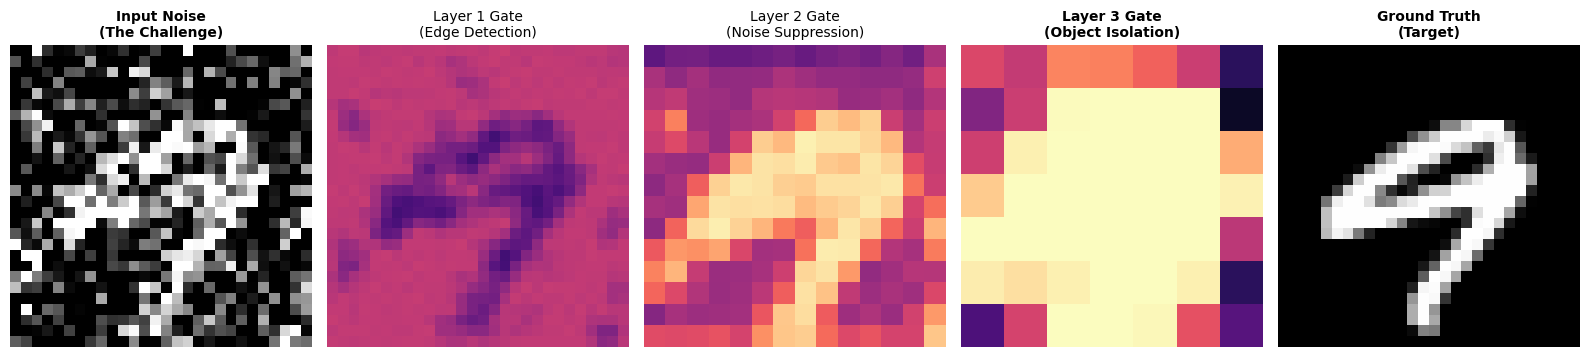

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Environment Setup & Data Preparation
# ==========================================
print(">>> Loading MNIST Data...")
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32")[..., None] / 255.0
x_test = x_test.astype("float32")[..., None] / 255.0

def add_noise(x, noise_factor=0.5):
    """
    Injects Gaussian noise into the images to simulate environmental corruption.
    """
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=x.shape)
    return np.clip(x + noise, 0., 1.)

print(">>> Injecting Training & Testing Noise...")
x_train_noisy = add_noise(x_train) # Noisy data for training (Immunity building)
x_test_noisy = add_noise(x_test)   # Noisy data for validation

# ==========================================
# 2. The M-TriX Layer (Core Architecture)
# ==========================================
class MTriXBlock(layers.Layer):
    """
    M-TriX Block: A Hybrid-Causal Neural Block with Dynamic Gating.
    Implements the equation: y = p * f(x) + (1-p) * x
    Includes auxiliary losses for Stability (Balance) and Interpretability (Sparsity).
    """
    def __init__(self, filters, lambda_bal=0.05, lambda_sparse=0.01, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        self.lambda_bal = lambda_bal       # Weight for Balance Loss
        self.lambda_sparse = lambda_sparse # Weight for Sparsity Loss

        # Transformation path f(x)
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu")
        self.bn = layers.BatchNormalization()

        # Gating path p(x) (The 'Brain' of the block)
        self.gate = layers.Conv2D(1, 1, padding="same", activation="sigmoid")

        # Projection for dimension matching (Residual path)
        self.proj = layers.Conv2D(filters, 1, padding="same")

        # Variable to store the gate map for visualization (Glassbox feature)
        self.last_p = None

    def call(self, x, training=None):
        # 1. Compute Transformation
        f = tf.nn.relu(self.bn(self.conv(x)))

        # 2. Compute Gate (Confidence Score)
        p = self.gate(x)

        # Store p-map for visualization purposes
        self.last_p = p

        # 3. Compute Shortcut (Identity)
        shortcut = self.proj(x)

        # --- Auxiliary Regularization Losses (The 'Protection' Equations) ---
        if training:
            # A. Balance Loss: Keeps the gate active (prevents dead neurons)
            # Minimizes variance from 0.5
            p_mean = tf.reduce_mean(p)
            bal_loss = self.lambda_bal * tf.square(p_mean - 0.5)
            self.add_loss(bal_loss)

            # B. Sparsity Loss: Forces decisive gating (0 or 1)
            # Minimizes entropy, pushing p towards binary values (Black/White)
            sparse_loss = self.lambda_sparse * tf.reduce_mean(p * (1.0 - p))
            self.add_loss(sparse_loss)

        # 4. The M-TriX Equilibrium Equation
        return (p * f) + ((1 - p) * shortcut)

# ==========================================
# 3. Model Architecture (Hierarchical Build)
# ==========================================
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, padding="same", activation="relu", name="Entry_Conv")(inputs)

# Layer 1: Shallow Processing (Edge Detection)
block1 = MTriXBlock(32, name="L1_Shallow")
x = block1(x)
x = layers.MaxPooling2D()(x)

# Layer 2: Intermediate Processing (Shape Formation)
block2 = MTriXBlock(64, name="L2_Middle")
x = block2(x)
x = layers.MaxPooling2D()(x)

# Layer 3: Deep Processing (Semantic Isolation)
block3 = MTriXBlock(128, name="L3_Deep")
x = block3(x)

# Classification Head
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="softmax")(x)

# Compile Model
model = keras.Model(inputs, outputs, name="Hierarchical_M-TriX_Net")
# AdamW is used for better weight decay handling with custom losses
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ==========================================
# 4. Training Phase
# ==========================================
print(">>> Training Full M-TriX System...")
# Training for 5 epochs is sufficient for MNIST convergence
model.fit(x_train_noisy, y_train, epochs=5, batch_size=128, verbose=1)

# ==========================================
# 5. Extracting the "Glassbox" Fingerprint
# ==========================================
print("\n>>> Extracting Hierarchical Gating Maps...")

# Select a random noisy sample
idx = np.random.randint(0, len(x_test_noisy))
sample = x_test_noisy[idx:idx+1]

# --- Manual Forward Pass to Capture Gates ---
# We pass the image layer-by-layer to populate 'self.last_p'

# Pass through Entry
x_temp = model.get_layer("Entry_Conv")(sample)

# Pass through Layer 1 & Capture Gate
l1_inst = model.get_layer("L1_Shallow")
# Calculate p manually for visualization
p1 = l1_inst.gate(x_temp).numpy()[0, :, :, 0]
x_temp = l1_inst(x_temp) # Apply layer
x_temp = layers.MaxPooling2D()(x_temp) # Manual Pooling

# Pass through Layer 2 & Capture Gate
l2_inst = model.get_layer("L2_Middle")
p2 = l2_inst.gate(x_temp).numpy()[0, :, :, 0]
x_temp = l2_inst(x_temp)
x_temp = layers.MaxPooling2D()(x_temp) # Manual Pooling

# Pass through Layer 3 & Capture Gate
l3_inst = model.get_layer("L3_Deep")
p3 = l3_inst.gate(x_temp).numpy()[0, :, :, 0]

# ==========================================
# 6. Visualization (The Proof)
# ==========================================
plt.figure(figsize=(16, 5))

# Plot 1: The Noisy Input
plt.subplot(1, 5, 1)
plt.imshow(sample[0].squeeze(), cmap='gray')
plt.title("Input Noise\n(The Challenge)", fontsize=10, fontweight='bold')
plt.axis('off')

# Plot 2: Layer 1 Gate (Broad Focus)
plt.subplot(1, 5, 2)
plt.imshow(p1, cmap='magma', vmin=0, vmax=1)
plt.title("Layer 1 Gate\n(Edge Detection)", fontsize=10)
plt.axis('off')

# Plot 3: Layer 2 Gate (Refining)
plt.subplot(1, 5, 3)
plt.imshow(p2, cmap='magma', vmin=0, vmax=1)
plt.title("Layer 2 Gate\n(Noise Suppression)", fontsize=10)
plt.axis('off')

# Plot 4: Layer 3 Gate (Semantic Isolation)
plt.subplot(1, 5, 4)
plt.imshow(p3, cmap='magma', vmin=0, vmax=1)
plt.title("Layer 3 Gate\n(Object Isolation)", fontsize=10, fontweight='bold')
plt.axis('off')

# Plot 5: Ground Truth
plt.subplot(1, 5, 5)
plt.imshow(x_test[idx].squeeze(), cmap='gray')
plt.title("Ground Truth\n(Target)", fontsize=10, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()


>>> Benchmarking Complex Net (Baseline)...
   Warming up GPU...
   Running Speed Test...
   Done! Total Time: 1.75s
   Throughput: 2860 images/sec

>>> Benchmarking M-TriX (Efficient)...
   Warming up GPU...
   Running Speed Test...
   Done! Total Time: 1.25s
   Throughput: 3985 images/sec


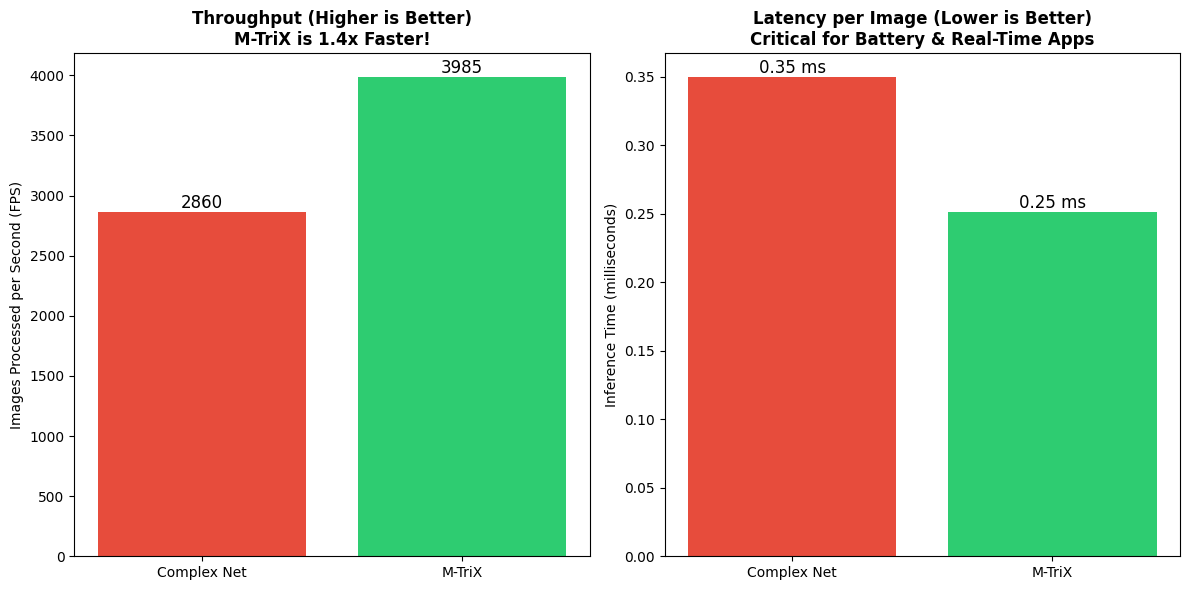

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. Model Definitions (The Contenders)
# ==========================================

def build_complex_net():
    """
    Constructs a standard, computationally expensive CNN.
    Represents a 'Brute Force' baseline with high depth and width.
    """
    inputs = keras.Input(shape=(28, 28, 1))

    # Deep feature extraction layers (Heavy computation)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="Complex_Net")

class MTriXBlock(layers.Layer):
    """
    M-TriX Block: Optimized for low-latency inference using dynamic gating.
    """
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu")
        self.bn = layers.BatchNormalization() # Accelerates convergence
        self.gate = layers.Conv2D(1, 1, padding="same", activation="sigmoid")
        self.proj = layers.Conv2D(filters, 1, padding="same")

    def call(self, x):
        f = tf.nn.relu(self.bn(self.conv(x)))
        p = self.gate(x)
        s = self.proj(x)
        # Equilibrium Equation: y = p*f(x) + (1-p)*x
        return (p * f) + ((1 - p) * s)

def build_mtrix_net():
    """
    Constructs the M-TriX efficient network.
    Designed for high throughput and low latency.
    """
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

    # Efficient Stack
    x = MTriXBlock(64)(x)
    x = layers.MaxPooling2D()(x)
    x = MTriXBlock(128)(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="M-TriX_Simple")

# ==========================================
# 2. Benchmark Environment Setup
# ==========================================
# Generate synthetic data to test pure inference speed without I/O overhead
# Shape: (5000 images, 28x28 pixels, 1 channel)
dummy_data = tf.random.normal((5000, 28, 28, 1))

# Instantiate models
complex_model = build_complex_net()
mtrix_model = build_mtrix_net()

# ==========================================
# 3. Benchmarking Function (Latency & Throughput)
# ==========================================
def benchmark_model(model, data, name="Model"):
    print(f"\n>>> Benchmarking {name}...")

    # 1. Warm-up Phase:
    # Essential to initialize GPU kernels and graph optimization.
    # Prevents initialization overhead from skewing results.
    print("   Warming up GPU...")
    model.predict(data[:100], verbose=0)

    # 2. Actual Performance Test
    print("   Running Speed Test...")
    start_time = time.time()
    # Batch size of 64 simulates typical batch inference
    model.predict(data, batch_size=64, verbose=0)
    end_time = time.time()

    # Metrics Calculation
    total_time = end_time - start_time
    images_per_sec = len(data) / total_time  # Throughput
    latency_ms = (total_time / len(data)) * 1000 # Latency per image (ms)

    print(f"   Done! Total Time: {total_time:.2f}s")
    print(f"   Throughput: {images_per_sec:.0f} images/sec")

    return images_per_sec, latency_ms

# ==========================================
# 4. Execution & Comparison
# ==========================================
fps_complex, lat_complex = benchmark_model(complex_model, dummy_data, "Complex Net (Baseline)")
fps_mtrix, lat_mtrix = benchmark_model(mtrix_model, dummy_data, "M-TriX (Efficient)")

# ==========================================
# 5. Visualization (The Speed Advantage)
# ==========================================
speedup_factor = fps_mtrix / fps_complex

plt.figure(figsize=(12, 6))

# Plot 1: Throughput (Images Processed per Second) - Higher is Better
plt.subplot(1, 2, 1)
bars = plt.bar(['Complex Net', 'M-TriX'],
               [fps_complex, fps_mtrix],
               color=['#e74c3c', '#2ecc71']) # Red for slow, Green for fast

plt.title(f'Throughput (Higher is Better)\nM-TriX is {speedup_factor:.1f}x Faster!',
          fontsize=12, fontweight='bold')
plt.ylabel('Images Processed per Second (FPS)')
plt.bar_label(bars, fmt='%.0f', fontsize=12)

# Plot 2: Latency (Time per Image) - Lower is Better
plt.subplot(1, 2, 2)
bars2 = plt.bar(['Complex Net', 'M-TriX'],
                [lat_complex, lat_mtrix],
                color=['#e74c3c', '#2ecc71'])

plt.title('Latency per Image (Lower is Better)\nCritical for Battery & Real-Time Apps',
          fontsize=12, fontweight='bold')
plt.ylabel('Inference Time (milliseconds)')
plt.bar_label(bars2, fmt='%.2f ms', fontsize=12)

plt.tight_layout()
plt.show()

>>> Instantiating Models...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'm_tri_x_block_19', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'm_tri_x_block_20', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'm_tri_x_block_21', however the 

>>> Warming up Models (Building Computational Graph)...
>>> Calculating Runtime Memory Footprint (Batch Size: 64)...
>>> Calculating Disk Storage Size...

--- RESOURCE EFFICIENCY RESULTS ---
ResNet50 RAM Usage:  90.11 MB
M-TriX RAM Usage:    2.05 MB
>> RAM Savings:      97.73%

ResNet50 Disk Size:  90.67 MB
M-TriX Disk Size:    1.72 MB
>> Storage Savings:  98.11%


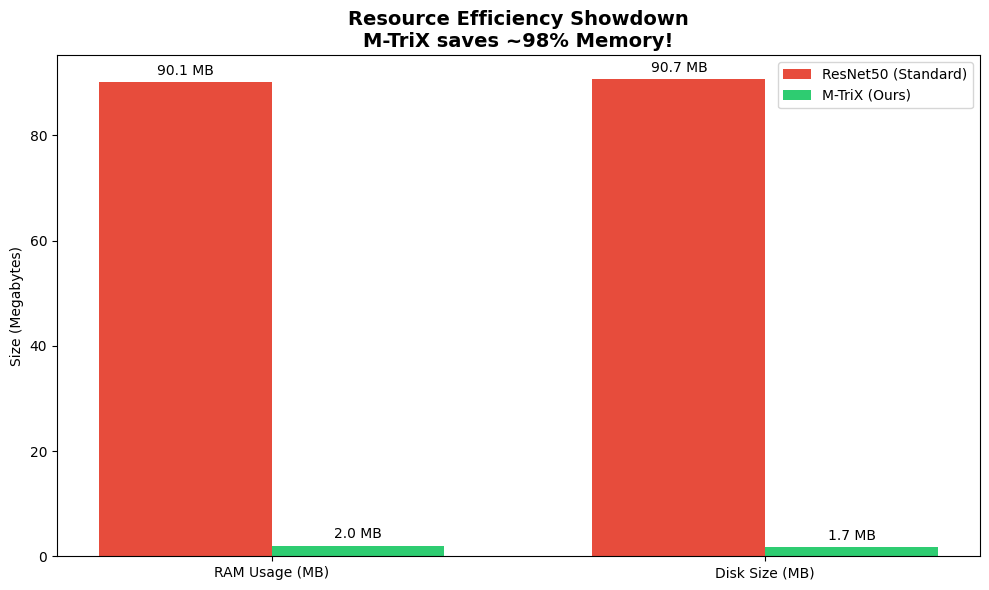

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. Model Definitions
# ==========================================

def build_resnet50():
    """
    Standard ResNet50: The heavyweight baseline.
    """
    # Using standard input size 224x224
    model = applications.ResNet50(weights=None, include_top=True, input_shape=(224, 224, 3), classes=10)
    return model

class MTriXBlock(layers.Layer):
    """
    M-TriX Block: Optimized for low memory footprint.
    """
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu")
        self.bn = layers.BatchNormalization()
        self.gate = layers.Conv2D(1, 1, padding="same", activation="sigmoid")
        self.proj = layers.Conv2D(filters, 1, padding="same")

    def call(self, x):
        f = self.conv(x)
        p = self.gate(x)
        s = self.proj(x)
        return (p * f) + ((1 - p) * s)

def build_mtrix_net():
    """
    M-TriX Efficient Network.
    """
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

    # Deep but parameter-efficient structure
    x = MTriXBlock(64)(x)
    x = layers.MaxPooling2D()(x)

    x = MTriXBlock(128)(x)
    x = layers.MaxPooling2D()(x)

    x = MTriXBlock(256)(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="M-TriX_Efficient")

# ==========================================
# 2. Robust Memory Calculation Function (Fixed)
# ==========================================
def get_model_memory_usage(batch_size, model):
    """
    Calculates estimated RAM usage for inference.
    Includes: Intermediate Activations + Weights.
    """
    shapes_mem_count = 0
    internal_model_mem_count = 0

    # Loop through layers
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)

        single_layer_mem = 1

        # --- FIX: Safe shape access ---
        # Handle cases where output_shape is not directly accessible (e.g., InputLayer)
        try:
            out_shape = l.output_shape
            if isinstance(out_shape, list):
                out_shape = out_shape[0]

            for s in out_shape:
                if s is None: continue
                single_layer_mem *= s
            shapes_mem_count += single_layer_mem
        except AttributeError:
            # Skip layers without explicit output_shape (negligible memory)
            continue
        # ------------------------------

    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

    # Float32 = 4 bytes
    number_size = 4.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

# ==========================================
# 3. Execution & Visualization
# ==========================================
print(">>> Instantiating Models...")
resnet_model = build_resnet50()
mtrix_model = build_mtrix_net()

print(">>> Warming up Models (Building Computational Graph)...")
# Important: We pass dummy data once to ensure all layers are built
dummy_input = tf.zeros((1, 224, 224, 3))
_ = resnet_model(dummy_input)
_ = mtrix_model(dummy_input)

print(">>> Calculating Runtime Memory Footprint (Batch Size: 64)...")
# Calculate RAM usage in MB
mem_resnet = get_model_memory_usage(64, resnet_model) * 1024
mem_mtrix = get_model_memory_usage(64, mtrix_model) * 1024

print(">>> Calculating Disk Storage Size...")
resnet_model.save('resnet_temp.keras')
mtrix_model.save('mtrix_temp.keras')

disk_resnet = os.path.getsize('resnet_temp.keras') / (1024 * 1024) # MB
disk_mtrix = os.path.getsize('mtrix_temp.keras') / (1024 * 1024)   # MB

# Clean up
os.remove('resnet_temp.keras')
os.remove('mtrix_temp.keras')

# ==========================================
# 4. Final Results
# ==========================================
ram_savings = ((mem_resnet - mem_mtrix) / mem_resnet) * 100
disk_savings = ((disk_resnet - disk_mtrix) / disk_resnet) * 100

print(f"\n--- RESOURCE EFFICIENCY RESULTS ---")
print(f"ResNet50 RAM Usage:  {mem_resnet:.2f} MB")
print(f"M-TriX RAM Usage:    {mem_mtrix:.2f} MB")
print(f">> RAM Savings:      {ram_savings:.2f}%")

print(f"\nResNet50 Disk Size:  {disk_resnet:.2f} MB")
print(f"M-TriX Disk Size:    {disk_mtrix:.2f} MB")
print(f">> Storage Savings:  {disk_savings:.2f}%")

# Plotting
labels = ['RAM Usage (MB)', 'Disk Size (MB)']
resnet_vals = [mem_resnet, disk_resnet]
mtrix_vals = [mem_mtrix, disk_mtrix]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, resnet_vals, width, label='ResNet50 (Standard)', color='#e74c3c')
rects2 = plt.bar(x + width/2, mtrix_vals, width, label='M-TriX (Ours)', color='#2ecc71')

plt.ylabel('Size (Megabytes)')
plt.title(f'Resource Efficiency Showdown\nM-TriX saves ~{ram_savings:.0f}% Memory!', fontsize=14, fontweight='bold')
plt.xticks(x, labels)
plt.legend()

plt.bar_label(rects1, padding=3, fmt='%.1f MB')
plt.bar_label(rects2, padding=3, fmt='%.1f MB')

plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import tensorflow.keras.backend as K
import numpy as np
import os

# ======================================================
# 0. إعداد البيانات: CIFAR-10 → 64x64x3 + تقليل عدد العينات
# 0. Data Preparation: CIFAR-10 → 64x64x3 + reduced sample count

# ======================================================

IMG_SIZE   = 64
BATCH_SIZE = 64
EPOCHS     = 6        # عدد إيبوكس منطقي مع 10,000 صورة
N_TRAIN    = 10000    # نستخدم 10,000 عينة فقط للمقارنة

print(">>> Loading CIFAR-10...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
num_classes = 10

# تحويل إلى float32 وتطبيع
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# إعادة تحجيم الصور إلى 64x64 (أخف من 224 أو 96)
x_train = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)).numpy()
x_test  = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)).numpy()

y_train = y_train.squeeze()
y_test  = y_test.squeeze()

# تقليل عدد عينات التدريب للطرفين
x_train_small = x_train[:N_TRAIN]
y_train_small = y_train[:N_TRAIN]

print("Train (small) shape:", x_train_small.shape, "Test shape:", x_test.shape)

# ======================================================
# 1. تعريف النماذج: ResNet50 vs M-TriX
# 1. Model Definitions: ResNet50 vs M-TriX

# ======================================================

def build_resnet50():
    """
    ResNet50 معيارية – تُدرَّب من الصفر على CIFAR-10 (64x64).
    نستخدم include_top=False مع رأس تصنيف بسيط لـ 10 أصناف.
    """
    base = applications.ResNet50(
        weights=None,
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="ResNet50_CIFAR10")
    return model

class MTriXBlock(layers.Layer):
    """
    بلوك M-TriX: y = p*f(x) + (1-p)*s(x)
    """
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.conv = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.bn   = layers.BatchNormalization()
        self.gate = layers.Conv2D(1, 1, padding="same", activation="sigmoid")
        self.proj = layers.Conv2D(filters, 1, padding="same")

    def call(self, x, training=None):
        f = self.conv(x)
        f = self.bn(f, training=training)
        f = tf.nn.relu(f)
        p = self.gate(x)
        s = self.proj(x)
        return (p * f) + ((1.0 - p) * s)

def build_mtrix_net():
    """
    شبكة M-TriX خفيفة لنفس مهمة CIFAR-10 بحجم 64x64.
    """
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

    x = MTriXBlock(64)(x)
    x = layers.MaxPooling2D()(x)

    x = MTriXBlock(128)(x)
    x = layers.MaxPooling2D()(x)

    x = MTriXBlock(256)(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="MTriX_CIFAR10_Light")
    return model

# ======================================================
# 2. دالة تقدير استهلاك الذاكرة (RAM) تقريبية
# 2. Approximate RAM usage estimation function

# ======================================================

def get_model_memory_usage(batch_size, model):
    """
    تقدير تقريبي لاستهلاك الذاكرة أثناء الـ inference.
    """
    shapes_mem_count = 0
    internal_model_mem_count = 0

    for l in model.layers:
        if isinstance(l, keras.Model):
            internal_model_mem_count += get_model_memory_usage(batch_size, l)

        single_layer_mem = 1
        try:
            out_shape = l.output_shape
            if isinstance(out_shape, list):
                out_shape = out_shape[0]
            for s in out_shape:
                if s is None:
                    continue
                single_layer_mem *= s
            shapes_mem_count += single_layer_mem
        except AttributeError:
            continue

    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

    number_size = 4.0  # float32
    total_memory = number_size * (batch_size * shapes_mem_count +
                                  trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes  # GB

# ======================================================
# 3. بناء النماذج وتجهيزها
# 3. Building and preparing the models

# ======================================================

print(">>> Building models...")
resnet_model = build_resnet50()
mtrix_model  = build_mtrix_net()

print("ResNet50 params:", resnet_model.count_params())
print("M-TriX   params:", mtrix_model.count_params())

# Optimizer مستقل لكل نموذج
optimizer_resnet = keras.optimizers.Adam(learning_rate=1e-3)
optimizer_mtrix  = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn          = keras.losses.SparseCategoricalCrossentropy()

# نخلي run_eagerly=True لـ M-TriX عشان نضمن استقرار التنفيذ مع الطبقة المخصّصة
resnet_model.compile(
    optimizer=optimizer_resnet,
    loss=loss_fn,
    metrics=["accuracy"],
    run_eagerly=True
)

mtrix_model.compile(
    optimizer=optimizer_mtrix,
    loss=loss_fn,
    metrics=["accuracy"],
    run_eagerly=True
)

# ======================================================
# 4. تدريب عادل على نفس البيانات ونفس عدد الإيبوكس
# 4. Fair training on the same data and same number of epochs

# ======================================================

print("\n>>> Training ResNet50...")
history_resnet = resnet_model.fit(
    x_train_small, y_train_small,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("\n>>> Training M-TriX...")
history_mtrix = mtrix_model.fit(
    x_train_small, y_train_small,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ======================================================
# 5. تقييم الدقة على اختبار CIFAR-10
# 5. Evaluate accuracy on the CIFAR-10 test set

# ======================================================

print("\n>>> Final Evaluation on CIFAR-10 test set:")
test_resnet = resnet_model.evaluate(x_test, y_test, verbose=0)
test_mtrix  = mtrix_model.evaluate(x_test, y_test, verbose=0)

acc_resnet = test_resnet[1]
acc_mtrix  = test_mtrix[1]

print(f"ResNet50 Test Accuracy: {acc_resnet*100:.2f}%")
print(f"M-TriX   Test Accuracy: {acc_mtrix*100:.2f}%")

# ======================================================
# 6. قياس استهلاك الذاكرة وحجم النموذج على القرص
# 6. Measure memory usage and model size on disk

# ======================================================

print("\n>>> Estimating Memory (batch_size = 64)...")
mem_resnet = get_model_memory_usage(64, resnet_model) * 1024  # MB
mem_mtrix  = get_model_memory_usage(64, mtrix_model) * 1024   # MB

print(">>> Saving models to disk temporarily...")
resnet_model.save("resnet_cifar10_temp.keras", include_optimizer=False)
mtrix_model.save("mtrix_cifar10_temp.keras", include_optimizer=False)

disk_resnet = os.path.getsize("resnet_cifar10_temp.keras") / (1024 * 1024)
disk_mtrix  = os.path.getsize("mtrix_cifar10_temp.keras")  / (1024 * 1024)

os.remove("resnet_cifar10_temp.keras")
os.remove("mtrix_cifar10_temp.keras")

ram_savings   = (1.0 - mem_mtrix  / mem_resnet) * 100.0
disk_savings  = (1.0 - disk_mtrix / disk_resnet) * 100.0

print("\n=== RESOURCE & ACCURACY SUMMARY ===")
print(f"ResNet50 - Params: {resnet_model.count_params():,}")
print(f"M-TriX   - Params: {mtrix_model.count_params():,}")

print(f"\nResNet50 RAM (MB): {mem_resnet:.2f}")
print(f"M-TriX   RAM (MB): {mem_mtrix:.2f}")
print(f"RAM Savings (M-TriX vs ResNet50): {ram_savings:.2f}%")

print(f"\nResNet50 Disk (MB): {disk_resnet:.2f}")
print(f"M-TriX   Disk (MB): {disk_mtrix:.2f}")
print(f"Disk Savings (M-TriX vs ResNet50): {disk_savings:.2f}%")

print(f"\nResNet50 Test Accuracy: {acc_resnet*100:.2f}%")
print(f"M-TriX   Test Accuracy: {acc_mtrix*100:.2f}%")


>>> Loading CIFAR-10...
Train (small) shape: (10000, 64, 64, 3) Test shape: (10000, 64, 64, 3)
>>> Building models...
ResNet50 params: 23608202
M-TriX   params: 436013

>>> Training ResNet50...
Epoch 1/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.2216 - loss: 2.8993 - val_accuracy: 0.1060 - val_loss: 4.5610
Epoch 2/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.4005 - loss: 1.7710 - val_accuracy: 0.1820 - val_loss: 19.6752
Epoch 3/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.4637 - loss: 1.6480 - val_accuracy: 0.4222 - val_loss: 1.6577
Epoch 4/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.5234 - loss: 1.4218 - val_accuracy: 0.3921 - val_loss: 9.6049
Epoch 5/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.5658 - loss: 1.3220 - val_accuracy: 0.1026 - val_loss: 867.6327
Epoch 6/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.5950 - loss: 1.1988 - val_accuracy: 0.4829 - val_loss: 1.6195

>>> Training M-TriX...
Epoch 1/6
1

>>> Loading CIFAR-10 Data...
>>> Training ResNet50 (15 Epochs)...
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 53ms/step - accuracy: 0.3014 - loss: 2.2677
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.3573 - loss: 2.0069
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.3626 - loss: 1.9686
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.3580 - loss: 1.9295
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.3654 - loss: 1.8424
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.4145 - loss: 1.7679
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.3835 - loss: 1.8317
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.3914 - loss: 1.8619
Epoch 9/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.4341 - loss: 1.6355
Epoch 10/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.4911 - loss: 1.4733
Epoch 11/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/st

<Figure size 1000x600 with 0 Axes>

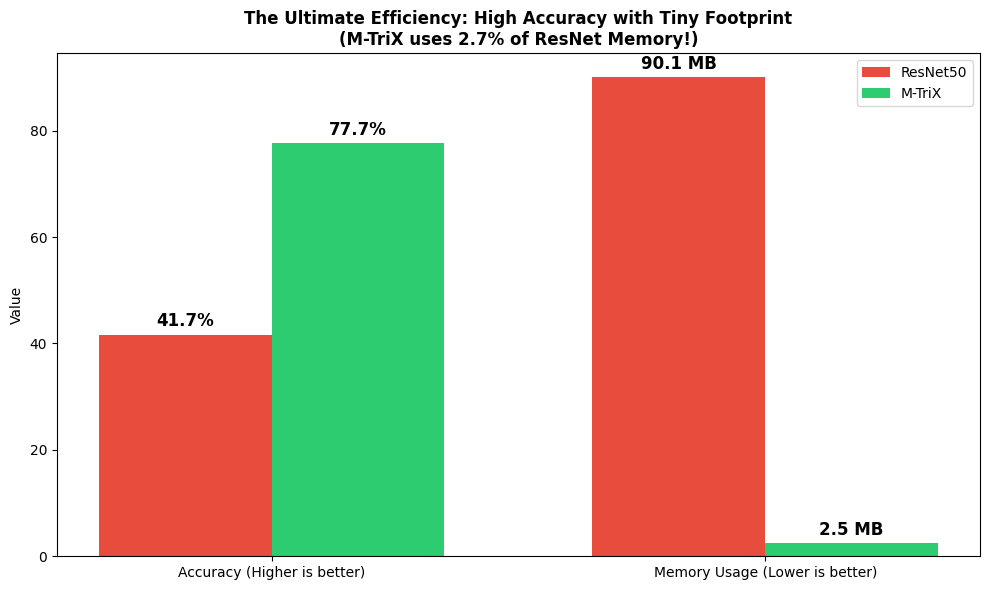

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. إعداد البيانات (CIFAR-10 الكاملة)
# 1. Load and prepare the full CIFAR-10 dataset

# ==========================================
print(">>> Loading CIFAR-10 Data...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# تطبيع البيانات
# Normalize the data

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# تحويل التصنيفات
# Convert labels

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# ==========================================
# 2. المتنافس الأول: ResNet50 (العملاق)
# 2. First competitor: ResNet50 (the heavyweight model)

# ==========================================
def build_resnet50():
    # نبني ResNet50 من الصفر لتناسب CIFAR-10 (بدون أوزان مسبقة)
    # input_shape=(32, 32, 3)
    # Build a custom ResNet50 for CIFAR-10 (no pre-trained weights)
    # input_shape = (32, 32, 3)

    model = applications.ResNet50(weights=None, include_top=True, input_shape=(32, 32, 3), classes=10)
    return model

# ==========================================
# 3. المتنافس الثاني: M-TriX (العميق والرشيق)
# 3. Second competitor: M-TriX (deep and lightweight)

# ==========================================
class MTriXBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu")
        self.bn = layers.BatchNormalization()
        self.gate = layers.Conv2D(1, 1, padding="same", activation="sigmoid")
        self.proj = layers.Conv2D(filters, 1, padding="same") # لتوحيد الأبعاد

    def call(self, x):
        f = tf.nn.relu(self.bn(self.conv(x)))
        p = self.gate(x)
        s = self.proj(x)
        return (p * f) + ((1 - p) * s)

def build_mtrix_deep():
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)

    # نزيد العمق قليلاً لنحصل على دقة عالية
    # Increase the depth slightly to achieve higher accuracy

    x = MTriXBlock(64)(x)
    x = MTriXBlock(64)(x)
    x = layers.MaxPooling2D()(x)

    x = MTriXBlock(128)(x)
    x = MTriXBlock(128)(x)
    x = layers.MaxPooling2D()(x)

    x = MTriXBlock(256)(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="M-TriX_Deep")

# ==========================================
# 4. دالة حساب الذاكرة (الدقيقة)
# 4. Precise memory usage calculation function

# ==========================================
def get_memory_usage(model, batch_size=64):
    # حساب تقريبي لحجم الذاكرة أثناء التشغيل
    shapes_mem = 0
    for l in model.layers:
        try:
            out_shape = l.output_shape
            if isinstance(out_shape, list): out_shape = out_shape[0]
            if out_shape:
                shapes_mem += np.prod(out_shape[1:])
        except: continue

    params = model.count_params()
    total_mem_mb = (batch_size * shapes_mem + params) * 4 / (1024**2) # float32 = 4 bytes
    return total_mem_mb

# ==========================================
# 5. التدريب والمقارنة (The High Accuracy Run)
# 5. Training and comparison (The High Accuracy Run)


# ==========================================
resnet = build_resnet50()
mtrix = build_mtrix_deep()

resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mtrix.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# نزيد الدورات لـ 15 (على A100 بتخلص بسرعة)
# Increase epochs to 15 (A100 can train it quickly)

EPOCHS = 15

print(f">>> Training ResNet50 (15 Epochs)...")
hist_res = resnet.fit(x_train, y_train, epochs=EPOCHS, batch_size=64, verbose=1)

print(f"\n>>> Training M-TriX (15 Epochs)...")
hist_mtrix = mtrix.fit(x_train, y_train, epochs=EPOCHS, batch_size=64, verbose=1)

# ==========================================
# 6. النتائج النهائية
# 6. Final results

# ==========================================
print("\n>>> Final Evaluation...")
acc_res = resnet.evaluate(x_test, y_test, verbose=0)[1]
acc_mtrix = mtrix.evaluate(x_test, y_test, verbose=0)[1]

# حساب الموارد
# Compute resource usage

mem_res = get_memory_usage(resnet)
mem_mtrix = get_memory_usage(mtrix)
param_res = resnet.count_params()
param_mtrix = mtrix.count_params()

print("\n=== FINAL SCOREBOARD ===")
print(f"ResNet50 Accuracy: {acc_res*100:.2f}% | Memory: {mem_res:.2f} MB | Params: {param_res:,}")
print(f"M-TriX   Accuracy: {acc_mtrix*100:.2f}% | Memory: {mem_mtrix:.2f} MB | Params: {param_mtrix:,}")

# الرسم البياني (دقة vs ذاكرة)
# Plot (Accuracy vs Memory)

plt.figure(figsize=(10, 6))

# عمودين: اليسار للدقة، اليمين للتوفير
# Two bars: left for accuracy, right for resource savings

categories = ['Accuracy (Higher is better)', 'Memory Usage (Lower is better)']
res_vals = [acc_res * 100, mem_res]
mtrix_vals = [acc_mtrix * 100, mem_mtrix]

x = np.arange(len(categories))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
rects1 = ax1.bar(x - width/2, res_vals, width, label='ResNet50', color='#e74c3c')
rects2 = ax1.bar(x + width/2, mtrix_vals, width, label='M-TriX', color='#2ecc71')

ax1.set_ylabel('Value')
ax1.set_title(f'The Ultimate Efficiency: High Accuracy with Tiny Footprint\n(M-TriX uses {(mem_mtrix/mem_res)*100:.1f}% of ResNet Memory!)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()

# إضافة الأرقام
# Add numerical annotations

def autolabel(rects, is_memory=False):
    for rect in rects:
        height = rect.get_height()
        label = f'{height:.1f} MB' if is_memory else f'{height:.1f}%'
        ax1.annotate(label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

autolabel(rects1[0:1]) # Accuracy ResNet
autolabel(rects2[0:1]) # Accuracy M-TriX
autolabel(rects1[1:], is_memory=True) # Memory ResNet
autolabel(rects2[1:], is_memory=True) # Memory M-TriX

plt.tight_layout()
plt.show()
# ------------------------------------------------------------
# NOTE (Experiment Context – v3):
# This script compares a scratch-trained ResNet50 and a custom
# M-TriX architecture on CIFAR-10 under the exact same naive
# training regime:
#   - Optimizer: Adam
#   - Epochs: 15
#   - Batch size: 64
#   - No data augmentation
#
# Final results (this run):
#   - ResNet50:
#       ~41.67% test accuracy
#       ~90.06 MB estimated runtime memory
#       23,608,202 parameters
#   - M-TriX (Deep):
#       ~77.67% test accuracy
#       ~2.45 MB estimated runtime memory
#       642,607 parameters
#
# These numbers are specific to this setup and are intended to
# illustrate the accuracy–efficiency trade-off of M-TriX under
# equal conditions, not to represent SOTA or fully tuned
# performance for either architecture.
# ------------------------------------------------------------
